# Does what happen in Vegas, Really Stay in Vegas? 
# Brain wave signal analysis of alcoholics and non-alcoholic subject groups

# Question: 

### Can Alcoholism/ predisposition to alcoholism be identifed by deep learning?



### Part 1: Introduction and Background

### Objective: Create a project that takes raw sensor data, and coverts it into  something usable by high level AI models

###  Background information on Alcohol Dependance/Alcoholism

Alcoholism is a complex subject with a wide range of causes and risk factors including: 

1. Inherited Traits (Not caused directly by alcohol use)
2. Psychological
  a. Beliefs about Alcohol
  b. Mental Illness (Bipolar Disorder and Depression)
3. Familial Factors (having alcoholic family members)
4. Enviromental Factors (Workplace stress, or Unemployment)
5. Religious, Social, and Cultural Factors
  a. Living in areas where alcohol use is accepted or shunned










### Brain wave background information

The brain emits a weak electromagnetic field that can be measured via electrodes placed on the scalp

Five types of Brain waves: 

Beta: Assosiated with waking, alert conciousness
Alpha: Assosiated with waking, relaxed conciousness (index of relaxation)
Theta: Assosiated with sleep and meditation
Delta: Assosiated with deep sleep and deep meditation
Gamma: Assosiated with REM sleep (dreaming) and trained monks


### Differences between the two groups 

# Alpha Brain waves: Alcoholics have been shown to have poor alpha rythnm

# Beta Brain Waves: Shown to have statistically significant differences. 

Spacial: Occipital, Temporal lobes, and frontal regions shown to have higher levels of beta waves. 

Qualitative differences: Alcoholics exhibit higher beta frequencies than non alcoholics, who have lower brain waves


### Main point: there is scientific evidence that alcoholics have different brain waves




![brainwavebands.png](https://i.imgur.com/Sc3bWh7.png)
Credit to Muse


### Part 2: Preparing the data/ Feature Extraction 

Feature extraction:

Time
Sensor placement
Amplitude
Frequency
Power

Frequency changes
(at what time is a frequency present or not present in a signal)




### Part 3: Training the model attempt 1 & 2:

### Attempt one:

Features: 

Sensor placement
Frequency (Beta, Alpha, Theta) 
Power
(Time information  not included in the model)  


Attempt 1: Failure and re evaluation

Attempt 2: (looking at beta frequency bands)
slight improvment and encouragement

### Part 4: A new model: feature extraction part 2

Features:

Time 
Power
Frequency
Changes in frequency
Sensor placement

Attempt 1 and Attempt 2

### Part 5: final analysis

Success and failures

correlation != high accuracy

Food for thought


![image.png](https://i.imgur.com/lcJh2JJ.png)

# Part 1 Setup

##### imports



In [ ]:
# Imports 

# initalize drive
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz mne


In [ ]:

#import fastbook

#drive.flush_and_unmount()
#drive.mount('/content/drive')
#fastbook.setup_book()

# Part 1 Feature extraction

# Base libraries
from multiprocessing import Pool

import os
import numpy as np
import mne
import pandas as pd
import random

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
import mne
import matplotlib 
from collections import defaultdict
from math import cos, sin, acos, radians, pi
from scipy.interpolate import griddata
from numpy import newaxis
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


# Wavelets 
import pywt

In [ ]:
drive.mount('/content/drive')


In [ ]:
# Importing the data using multiprocessing

# 10x speed increase for reading 900 csv files


train_dir = '/content/drive/My Drive/Colab_Data/EEG/SMNI_CMI_TRAIN/Train/'
test_dir = '/content/drive/My Drive/Colab_Data/EEG/SMNI_CMI_TEST/Test/'

# wrap your csv importer in a function that can be mapped
def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)


# get a list of file names
files_train = os.listdir(train_dir)
file_list_train = [os.path.join(train_dir,filename) for filename in files_train if filename.split('.')[1]=='csv']
                     
files_test = os.listdir(test_dir)
file_list_test = [os.path.join(test_dir,filename) for filename in files_test if filename.split('.')[1]=='csv']
                     
# set up your pool
with Pool(processes=12) as pool:

    # pool maps the dataframe


    df_list_train = pool.map(read_csv, file_list_train)
    df_list_test =  pool.map(read_csv, file_list_test)


# reduce the list of dataframes to a single dataframe
combined_df_train = pd.concat(df_list_train, ignore_index=True)
combined_df_test = pd.concat(df_list_test, ignore_index=True)
combined_df = pd.concat([combined_df_train,combined_df_test], ignore_index=True)


EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

del combined_df

# Data Wrangling (renaming columns and indexing the trials) 

In [ ]:
# standardizing the sensor position naming convention

# Training set 

EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name  

## replace some 'senso4/1AX4XfWjxIbaBk1mjB1EGwKxLgAcVGZ4jYKlCxUrTC3J6zb1GcEgabB3B9bMr position' values
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data.loc[EEG_data['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data.loc[EEG_data['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data.loc[EEG_data['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data.loc[EEG_data['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data.loc[EEG_data['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data.loc[EEG_data['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data.loc[EEG_data['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data.loc[EEG_data['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data.loc[EEG_data['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data.loc[EEG_data['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data.loc[EEG_data['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

## Control Group


EEG_data_control = EEG_data_control.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data_control.loc[EEG_data_control['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name    
## replace some 'sensor position' values
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data_control.loc[EEG_data_control['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

In [ ]:
# Organzing according to experiment condition groups

#Alc_Groups
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']
Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']
Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']

#Control groups 
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']
Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']
Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']


def trial_len_integrity_check(inputDF):

  nameAndTrialNumber = inputDF.groupby(['trial number','name']).size().reset_index().rename(columns={0:'count'})
  nameAndTrialNumber['count'] =np.where(nameAndTrialNumber['count'] == 16384,False,True)

  del inputDF

  if nameAndTrialNumber['count'].any():
    # data integrity problem
    Exception('Data Integrity problem, one of the arrays is not shaped 256x256')
  #nameAndTrialNumber.drop(['count'],axis=1)

  return nameAndTrialNumber[['trial number','name']]


# Creating dataframes that contain relevant indexing information and checks data integrity
# Trial Number, and subject names 

Con_S1Obj_Index = trial_len_integrity_check(Con_S1Obj) 
Con_S2Match_Index = trial_len_integrity_check(Con_S2Match) 
Con_S2Nomatch_Index = trial_len_integrity_check(Con_S2Nomatch) 

Alc_S1Obj_Index = trial_len_integrity_check(Alc_S1Obj) 
Alc_S2Match_Index = trial_len_integrity_check(Alc_S2Match) 
Alc_S2Nomatch_Index = trial_len_integrity_check(Alc_S2Nomatch) 

All_Alcs = pd.concat([Alc_S1Obj_Index,Alc_S2Match_Index,Alc_S2Nomatch_Index])
All_Cons = pd.concat([Con_S1Obj_Index,Con_S2Match_Index,Con_S2Nomatch_Index])

All_Alcs.reset_index(drop=True,inplace=True)
All_Cons.reset_index(drop=True,inplace=True)


# Feature Extraction (success and failures

### Problems

Raw time series data has excellent temporal (time axis) accuracy,
but has no information on frequency because it is raw data


Rather, what we need is to fit this into a model for an electromatic wave, so that 
we can get frequency information.



### Solutions

Fourier Transform

Wavlet Transform

In [ ]:
# visualizing the time series channels
TrueCrimeSubjectZero = EEG_data[((EEG_data.name == 'co2a0000364') & (EEG_data['trial number'] == 0))]
print('Number of data points on example subject Zero, Trial Zero')
print(TrueCrimeSubjectZero.shape)
print('Number of Channels')
print(TrueCrimeSubjectZero.shape[0] / 256)
print('Sampling Rate')
print(TrueCrimeSubjectZero.shape[0] / 64)

In [ ]:
# Examining one channel
oneSensor = TrueCrimeSubjectZero[TrueCrimeSubjectZero['sensor position'] == 'Fp1']

time = oneSensor['time']
sensorValue = oneSensor['sensor value']

plt.plot(time,sensorValue)
plt.show()


![image.png](https://i.imgur.com/cZmdOcK.png)

# This time series plot is actually composed of many

# different frequency waves. What you see are the low frequencies which have large wavelengths

# The high frequencies get drowned out by the other waves

# So different frequency bands need to be extracted

In [ ]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 256 * 1 # 256 htz for one second

yf = abs(fft(sensorValue.astype(np.int64)))
PowerFilterIndex =  np.where(yf >= 200)[0]
#yf = np.delete(yf,PowerFilterIndex)
yf[PowerFilterIndex] = 200

variance = np.std(yf)**2
#fft_power = variance * abs(yf)

N = len(yf)

xf = abs(fftfreq(N, 1 / 100))

print(len(yf))
# Values above 60 htz are removed they are likely noise generated by electrical devices 

plt.bar(xf, yf)
plt.show()

# Frequency Power information


![image.png](https://i.imgur.com/qlrSv9u.png)

## Interpreting the graph

This graph (cut off at 200) shows the power of each frequency from 0 to 50 hertz. Around 60 htz there is noise from electronics operating at that frequency, so it is cut off here. As you can see, the majority of the signal is between 0-30 htz

### Benefits of using Fourier Transform:

### Produces detailed information on the frequencies present in the signal

### Drawbacks

### Does not have information about when the frequency was present in the signal

# Extracting features Through a Wavelet Transform 

Since the research shows that alcoholics's brainwaves are more unstable than the control we need a way to infer the quality of the signal. Instead of only having the power of each frequency, we need a way to know when certain frequencies are present. 

This is where a wavelet transform serves as a superior model to represent the raw signal. These wavelets contain more information, and are often used in audio and image compression.  

![image.png](https://i.imgur.com/HYtAa8M.png)

In [ ]:
t = 0.5
time = np.arange(0,256,1)
scales = [0.1,4.3,7.3,21.3,32,64,512]
x = yf
signal = sensorValue

def plot_wavelet(ax, time, signal, scales, waveletname = 'morl', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = 0.5

    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    #print(frequencies.max())
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    #levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    levels = [0.1,4.3,7.3,21.3,32,64,512]

    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    #ax.set_yticks(np.log2(yticks))
    #ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

#scales = [1,2,4,8,16]#np.arange(1, 256)

fig, ax = plt.subplots(figsize=(4, 4))
plot_wavelet(ax, time, signal, scales, xlabel='', ylabel='', title='')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.margins(x=0,y=0)
plt.tight_layout(pad=0, rect=(0,0,0,0))
plt.show()

![image.png](https://i.imgur.com/iKtYhyf.png)

### Benefits of the wavelet transform

##### These graphs contain information on not only the frequencies contained within the signal, but also when they are present. These images can be interpreted by an AI image classifier. 

### Drawbacks

Before, we had too little information, whereas now we have too much. Transforming all 64 channels results in having 64 graphs, many of which are highly correlated. To move forward, a way has to be found to deal with the correlation problem. 

# So, an attempt to do both will be made, first with the Fourier transform, and the second with the wavelet transform

# Attempt 1
# Extracting Frequency / Power using Fourier Transform

#### Many thanks and credit to Thomas Rider 

link to notebook: https://www.kaggle.com/xridet48/eeg-images-vs-features-autoencoder


In [ ]:
from google.colab import files
files.upload() # Upload plotting_10005.txt
# File easily found with a google search of: EEG plotting_10005.txt

## Extract frequency band_power information function

In [ ]:
def extract_frequency_band_power_information(input_data):

    coords = pd.read_csv('/content/plotting_1005.txt', sep='\t',  header = None)
    coords = coords.drop(coords.columns[4], axis=1)

            #refactored to increase performance
    neeg = EEG_data.drop(columns=['matching condition','name','trial number', 'subject identifier','time', 'sample num', 'sensor value'])

    neeg = neeg.drop_duplicates()

    neeg = neeg.reset_index(drop=True)


    trials_dic = {}

    dbc = 0

    if Alc_base.shape == Con_base.shape:
        
        #print('Same shape error:')
        #print(Alc_base.shape)
        #print(Con_base.shape)
        raise SystemExit 

    if input_data.shape == Alc_base.shape[0]:
      dbc = EEG_data

    if input_data.shape == Con_base.shape[0]:
      dbc = EEG_data_control
    
    if input_data[0] == Alc_S1ObjTrials_fft[0]:

      dbc = Alc_S1Obj

    if input_data[0] == Alc_S2MatchTrials_fft[0]:

      dbc = Alc_S2Match

    if input_data[0] == Alc_S2NomatchTrials_fft[0]:

      dbc = Alc_S2Nomatch
#########################
      # Control

    if input_data[0] == Con_S1ObjTrials_fft[0]:

      dbc = Con_S1Obj

    if input_data[0] == Con_S2MatchTrials_fft[0]:

      dbc = Con_S2Match

    if input_data[0] == Con_S2NomatchTrials_fft[0]:

      dbc = Con_S2Nomatch


    # Removing the non condition trials if necessary


    for pos in input_data:
        #print(pos)
        #print(input_data.shape)
        #print(dbc)        
        
        fullTrialData = dbc[dbc['trial number'] == pos]

        # if filtered, drop the trials that don't fit the criterea 
        
        testSubjectNameList = fullTrialData.name.unique()
        #print(f'current {pos}')

        #print(f'subject id list length {testSubjectNameList}')
        for nameID in testSubjectNameList:
            trial_subject  = fullTrialData.loc[fullTrialData['name'] == nameID]
        #   print(nameID)

            frameName = str(pos) + '_' + nameID              
            trial_subject = trial_subject.pivot_table(index='channel', columns='time', values = 'sensor value')

            trials_dic[frameName] = trial_subject

    print('loop done, length of trials dictionary')
    print(len(trials_dic))
    #print(trials_dic.keys())



    RGB_dic = {}



    for key in trials_dic:
        #print(data.head(1))
        
        
        data = trials_dic.get(key)
        #print('starting data conversion')
        #print(data.shape)


      # if encountering the odd null value, uses a forward fill 
        #data = data.fillna(method='ffill')



        # Get real amplitudes of FFT (only in postive frequencies)

        fft_raw = fft(data)

        fft_vals = np.absolute(fft_raw)

        fft_vals = normalize(fft_vals, axis=1)

        # Get frequencies for amplitudes in Hz


        fs = 256    # Sampling rate

        fft_freq = fftfreq(fs, 1.0/fs)


        # Define EEG bands
        eeg_bands = {'Theta': (4, 7),
                  'Alpha': (8, 12),
                  'Beta': (13, 30),
                  }
        
        # Take the  sum of squared absolute values/amplitudes for each EEG band

        eeg_band_fft = defaultdict(list)

        for band in eeg_bands:  
        

            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                                (fft_freq <= eeg_bands[band][1]))[0]


            
            for channel in fft_vals:
        
                filterdch = channel[freq_ix]
                
                sqdvals = np.square(filterdch)
                
                sumvals = np.sum(sqdvals, axis=0)
                
                eeg_band_fft[band].append(sumvals)
                



        extracted_df =  pd.DataFrame(eeg_band_fft)




        extracted_df = extracted_df.reset_index(drop=True)
        neeg = neeg.reset_index(drop=True)



        e_names =  neeg
        e_names = e_names.rename(columns = {'sensor position' : 0})



        extracted_df = extracted_df.join(neeg)

        testerd = pd.merge(e_names, coords, on=0,  how='inner')


        testerd.set_index('channel', inplace=True)

        testerd.columns = ['pos','x', 'y', 'z']


        extracted_df = extracted_df.rename(columns={'sensor position': "pos"})

        #filter values and coordinates
        extracted_df = pd.merge(extracted_df, testerd, on="pos", how='inner')
        extracted_df = extracted_df.drop(['x','y','z'], axis=1)
        extracted_df.set_index('channel', inplace=True)

        extracted_df = extracted_df.drop(columns=['pos'])
        extracted_df.index.names = ['pos']
        #adapted from https://www.samuelbosch.com/2014/02/azimuthal-equidistant-projection.html

        class Point(object):
            def __init__(self,x, y, z):
                self.x = x
                self.y = y
                self.z = z

        class AzimuthalEquidistantProjection(object):
            """ 
                http://mathworld.wolfram.com/AzimuthalEquidistantProjection.html
                http://mathworld.wolfram.com/SphericalCoordinates.html
            """
            def __init__(self):

                self.t1 = pi / 2 ## polar latitude center of projection , https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection
                self.l0 = 0 ## arbitrary longitude center of projection
                self.cost1 = cos(self.t1)
                self.sint1 = sin(self.t1)
        
            def project(self, point):
        
                #ADDAPTED FOR 3D CARTESIAN TO SPHERICAL 
        
                hxy = np.hypot(point.x, point.y)
        
                t = np.arctan2(point.z, hxy)
                l = np.arctan2(point.y, point.x)
        
                ###
        
                costcosll0 = cos(t) * cos(l-self.l0)
                sint = sin(t)
        
                c = acos ((self.sint1) * (sint) + (self.cost1) * costcosll0)
                k = c / sin(c)
        
                x = k * cos(t) * sin(l-self.l0)
                y = k * (self.cost1 * sint - self.sint1 * costcosll0)
                return x, y


            
        #Projection df

        projected_df =  pd.DataFrame()

        for index, row in testerd.iterrows():

            x = row['x']
            y = row['y']
            z = row['z']


            p = AzimuthalEquidistantProjection()
            r = p.project(Point(x,y,z))

            r = pd.Series(r)

            projected_df = projected_df.append(r,ignore_index=True)
        

        projected_df =  projected_df.rename(columns={0: 'X',1: 'Y'})


        ###map coodinate with valuies

        new_df = projected_df.join(extracted_df)
        new_df = new_df.drop([31]) # drop row because i contains no values
        #print(new_df)

        Theta_df = new_df.drop(['Alpha','Beta','X','Y'], axis=1)
        Alpha_df = new_df.drop(['Theta','Beta','X','Y'], axis=1)
        Beta_df = new_df.drop(['Theta','Alpha','X','Y'], axis=1)
        

        #map onto mesh

        xpoints = np.array(new_df[['X']].squeeze())
        ypoints = np.array(new_df[['Y']].squeeze())

        Thetavalues = np.array(Theta_df).squeeze()
        Alphavalues = np.array(Alpha_df).squeeze()
        Betavalues = np.array(Beta_df).squeeze()
        

        xx,yy = np.mgrid[-1.5:1.5:32j, -1.5:1.5:32j]

        Thetavalues = minmax_scale(Thetavalues,feature_range=(0.0, 1.0), axis=0)
        Alphavalues = minmax_scale(Alphavalues,feature_range=(0.0, 1.0), axis=0)
        Betavalues = minmax_scale(Betavalues,feature_range=(0.0, 1.0), axis=0)



        Thetagrid = griddata((xpoints, ypoints), Thetavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Alphagrid = griddata((xpoints, ypoints), Alphavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Betagrid = griddata((xpoints, ypoints), Betavalues, (xx, yy),method='cubic', fill_value = 0.0)
      

        ##RGB construction

        RGB = np.empty((32, 32, 3))

        RGB[:,:,0] = Thetagrid
        RGB[:,:,1] = Alphagrid
        RGB[:,:,2] = Betagrid

        RGB_dic[key] = RGB
    ##creating new dict with new keys

    lendict = len(RGB_dic)
    #print('lendict: ',lendict)

    lenlist=np.arange(0,lendict)

    #print(lenlist)

    final_dict = dict(zip(lenlist, list(RGB_dic.values()))) 
    return final_dict

      

# Processing the images

In [ ]:
def pull_trial_numbers(input_data):
  trialNumbers = input_data['trial number'].unique()
  return trialNumbers



Alc_S1ObjTrials_fft = pull_trial_numbers(Alc_S1Obj)
Alc_S2MatchTrials_fft = pull_trial_numbers(Alc_S2Match)
Alc_S2NomatchTrials_fft = pull_trial_numbers(Alc_S2Nomatch)

Con_S1ObjTrials_fft = pull_trial_numbers(Con_S1Obj)
Con_S2MatchTrials_fft = pull_trial_numbers(Con_S2Match)
Con_S2NomatchTrials_fft = pull_trial_numbers(Con_S2Nomatch)

Alc_base = EEG_data['trial number'].unique()
Con_base = EEG_data_control['trial number'].unique()


#### mapping the channels onto a grid

In [ ]:

Alc_S1Obj_Dict_fft = extract_frequency_band_power_information(Alc_S1ObjTrials_fft)
Alc_S2Match_Dict_fft = extract_frequency_band_power_information(Alc_S2MatchTrials_fft)
Alc_S2Nomatch_Dict_fft = extract_frequency_band_power_information(Alc_S2NomatchTrials_fft)

Con_S1Obj_Dict_fft = extract_frequency_band_power_information(Con_S1ObjTrials_fft)
Con_S2Match_Dict_fft = extract_frequency_band_power_information(Con_S2MatchTrials_fft)
Con_S2Nomatch_Dict_fft = extract_frequency_band_power_information(Con_S2NomatchTrials_fft)

In [ ]:
alc_dict_fft = {}
con_dict_fft = {}

# Merging the output dictionaries


alc_dict_fft.update(Alc_S1Obj_Dict_fft)

next_dict_keys = [ key + len(alc_dict_fft) for key in Alc_S2Match_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Alc_S2Match_Dict_fft.values()))
alc_dict_fft.update(tmp_dict)

next_dict_keys = [ key + len(alc_dict_fft) for key in Alc_S2Nomatch_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Alc_S2Nomatch_Dict_fft.values()))
alc_dict_fft.update(tmp_dict)

########### merging the control dictionaries


con_dict_fft.update(Con_S1Obj_Dict_fft)

next_dict_keys = [ key + len(con_dict_fft) for key in Con_S2Match_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Con_S2Match_Dict_fft.values()))
con_dict_fft.update(tmp_dict)

next_dict_keys = [ key + len(con_dict_fft) for key in Con_S2Nomatch_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Con_S2Nomatch_Dict_fft.values()))
con_dict_fft.update(tmp_dict)



#Saving the images

In [ ]:
def save_array_as_image(inputDict,is_alc):
 # for i, (key,value) in enumerate(inputDict.items()):
  from PIL import Image
  if is_alc == True:
     is_alc = '_alc'
  else:
     is_alc = '_con'

  for k,v in inputDict.items():
    imName = str(k) + is_alc + '.jpg'
    im = Image.fromarray((v * 255).astype(np.uint8))
    im.save(imName)

In [ ]:
# directory setup (make your own )
%mkdir /home/james
%cd /home/james/

!mkdir EEG_Images_fft
%cd /home/james/EEG_Images_fft


!mkdir /home/james/EEG_Images_fft/Alc
!mkdir /home/james/EEG_Images_fft/Con


# Saving the images in directories for a dataloader to use later
%cd /home/james/EEG_Images_fft/Con
save_array_as_image(con_dict_fft,is_alc=False)

%cd /home/james/EEG_Images_fft/Alc
save_array_as_image(alc_dict_fft,is_alc=True)


## Exploring the Fourier Transform and Classification results

In [ ]:
%cd /home/james/

root_dir = "/home/james/EEG_Images_fft"
EEG_Con_Path = os.path.join(root_dir,'Con')
EEG_Alc_Path = os.path.join(root_dir,'Alc')

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]


# Exploration

In [ ]:
from fastbook import tensor
from fastbook import Image
from fastbook import show_image

In [ ]:
tensors_dict = {}

tensors_dict[0] = [tensor(Image.open(o)) for o in List_EEG_Con]
tensors_dict[1] = [tensor(Image.open(o)) for o in List_EEG_Alc]

stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255

    means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)
    show_image(means_dict[digit],)
    # first is for alcoholics
    # Second is for the control

In [ ]:
alcTheta_mean = stacked_tensors_dict[0][:,:,:,0].mean(0)
conTheta_mean = stacked_tensors_dict[1][:,:,:,0].mean(0)

alcAlpha_mean = stacked_tensors_dict[0][:,:,:,1].mean(0)
conAlpha_mean = stacked_tensors_dict[1][:,:,:,1].mean(0)

alcBeta_mean = stacked_tensors_dict[0][:,:,:,2].mean(0)
conBeta_mean = stacked_tensors_dict[1][:,:,:,2].mean(0)

# Findings

# Statistical Significance

### Findings are in line with the scientific literature

### Alcohol dependants show higher amounts of beta waves (higher frequency) versus alpha waves (lower frequency)

# Average Power of Theta Waves in Alcoholic and Control Groups


In [ ]:
show_image(alcTheta_mean,figsize=(5,5),title='Alcoholic average Theta Waves')

#

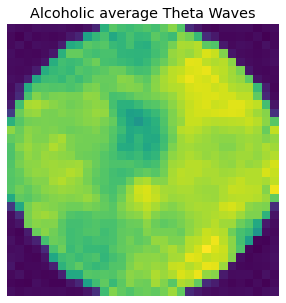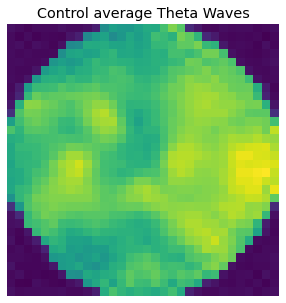

In [ ]:
show_image(conTheta_mean,figsize=(5,5),title='Control average Theta Waves')


# Average Power of Alpha waves in Alcoholic and Control Groups


In [ ]:
show_image(alcAlpha_mean,figsize=(5,5),title='Alcoholic average Alpha Waves')
show_image(conAlpha_mean,figsize=(5,5),title='Control average Alpha Waves')


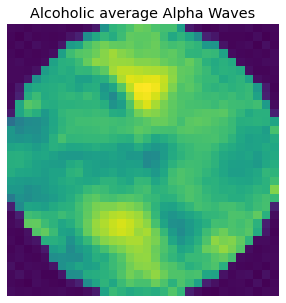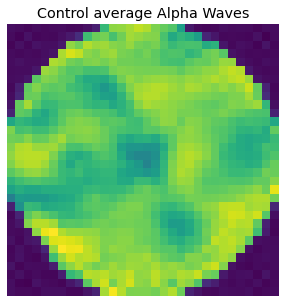

### Here, in the alpha band, differences start to show up

# Average Power of Beta waves in Alcoholic and Control Groups


In [ ]:
show_image(alcBeta_mean,figsize=(5,5),title='Alcoholic average Beta Waves')
show_image(conBeta_mean,figsize=(5,5),title='Control average Beta Waves')


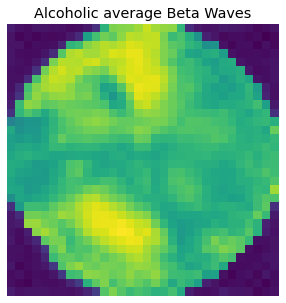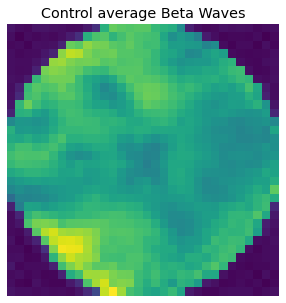

In the beta band, the differences start to become even more pronounced

# Inputting the data into a classifier

In [ ]:
%cd /home/james/

root_dir = "/home/james/EEG_Images_fft"
EEG_Con_Path = os.path.join(root_dir,'Con')
EEG_Alc_Path = os.path.join(root_dir,'Alc')

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]

NumOfControlImages = len(List_EEG_Con) 
NumOfAlchImages = len(List_EEG_Alc) 

print(f'Control Group size {NumOfControlImages}')
print(f'Alcholic Group size: {NumOfAlchImages}')

class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(32,32))

dls = EEGs.dataloaders
destination =Path(root_dir)
path = destination
fns = get_image_files(path)
dls = EEGs.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=16, nrows=4)

## These images are produced by overlaying the summed power of each three frequency bands, as the 64 channels are mapped to a circle as an RGB array. 

They were then inputting into a classifier based on resnet 18, which yielded 60% accuracy. A new approach would be needed to continue forward

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch	train_loss	valid_loss	error_rate	time

0	1.244782	0.770245	0.505435	00:07

num train_loss	valid_loss	error_rate	time

0	0.979887	0.813298	0.445652	00:13

1	0.909634	0.949886	0.429348	00:13

2	0.843650	0.890759	0.413043	00:13

3	0.741687	1.011093	0.418478	00:13

4	0.653198	1.035518	0.402174	00:13

5	0.569481	1.030253	**0.391304**	00:14

The final error rate is in bold above


# Beta Band information

### Here, as the next step of feature extraction, I looked for a way to focus on the key differences in the beta band, rather than a broad look 

Studies show that alcoholics have higher frequency beta waves than normal people (Rangaswamy et al. 2002) So, I went about making some modifications to the code to extract these frequency bands.

### Feature Extraction Code

In [ ]:
def extract_beta_frequency_band_power_information(input_data):

    coords = pd.read_csv('/content/plotting_1005.txt', sep='\t',  header = None)
    coords = coords.drop(coords.columns[4], axis=1)

            #refactored to increase performance
    neeg = EEG_data.drop(columns=['matching condition','name','trial number', 'subject identifier','time', 'sample num', 'sensor value'])

    neeg = neeg.drop_duplicates()

    neeg = neeg.reset_index(drop=True)


    trials_dic = {}

    dbc = 0

    if Alc_base.shape == Con_base.shape:
        
        #print('Same shape error:')
        #print(Alc_base.shape)
        #print(Con_base.shape)
        raise SystemExit 

    if input_data.shape == Alc_base.shape[0]:
      dbc = EEG_data

    if input_data.shape == Con_base.shape[0]:
      dbc = EEG_data_control
    
    if input_data[0] == Alc_S1ObjTrials_fft[0]:

      dbc = Alc_S1Obj

    if input_data[0] == Alc_S2MatchTrials_fft[0]:

      dbc = Alc_S2Match

    if input_data[0] == Alc_S2NomatchTrials_fft[0]:

      dbc = Alc_S2Nomatch
#########################
      # Control

    if input_data[0] == Con_S1ObjTrials_fft[0]:

      dbc = Con_S1Obj

    if input_data[0] == Con_S2MatchTrials_fft[0]:

      dbc = Con_S2Match

    if input_data[0] == Con_S2NomatchTrials_fft[0]:

      dbc = Con_S2Nomatch


    # Removing the non condition trials if necessary


    for pos in input_data:
        #print(pos)
        #print(input_data.shape)
        #print(dbc)        
        
        fullTrialData = dbc[dbc['trial number'] == pos]

        # if filtered, drop the trials that don't fit the criterea 
        
        testSubjectNameList = fullTrialData.name.unique()
        #print(f'current {pos}')

        #print(f'subject id list length {testSubjectNameList}')
        for nameID in testSubjectNameList:
            trial_subject  = fullTrialData.loc[fullTrialData['name'] == nameID]
        #   print(nameID)

            frameName = str(pos) + '_' + nameID              
            trial_subject = trial_subject.pivot_table(index='channel', columns='time', values = 'sensor value')

            trials_dic[frameName] = trial_subject

    print('loop done, length of trials dictionary')
    print(len(trials_dic))
    #print(trials_dic.keys())



    RGB_dic = {}



    for key in trials_dic:
        #print(data.head(1))
        
        
        data = trials_dic.get(key)
        #print('starting data conversion')
        #print(data.shape)


      # if encountering the odd null value, uses a forward fill 
        #data = data.fillna(method='ffill')



        # Get real amplitudes of FFT (only in postive frequencies)

        fft_raw = fft(data)

        fft_vals = np.absolute(fft_raw)

        fft_vals = normalize(fft_vals, axis=1)

        # Get frequencies for amplitudes in Hz


        fs = 256    # Sampling rate

        fft_freq = fftfreq(fs, 1.0/fs)


        # Define EEG bands
        eeg_bands = {'Theta': (11, 15),
                  'Alpha': (16, 20),
                  'Beta': (21, 28),
                  }
        
        # Take the  sum of squared absolute values/amplitudes for each EEG band

        eeg_band_fft = defaultdict(list)

        for band in eeg_bands:  
        

            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                                (fft_freq <= eeg_bands[band][1]))[0]


            
            for channel in fft_vals:
        
                filterdch = channel[freq_ix]
                
                sqdvals = np.square(filterdch)
                
                sumvals = np.sum(sqdvals, axis=0)
                
                eeg_band_fft[band].append(sumvals)
                



        extracted_df =  pd.DataFrame(eeg_band_fft)




        extracted_df = extracted_df.reset_index(drop=True)
        neeg = neeg.reset_index(drop=True)



        e_names =  neeg
        e_names = e_names.rename(columns = {'sensor position' : 0})



        extracted_df = extracted_df.join(neeg)

        testerd = pd.merge(e_names, coords, on=0,  how='inner')


        testerd.set_index('channel', inplace=True)

        testerd.columns = ['pos','x', 'y', 'z']


        extracted_df = extracted_df.rename(columns={'sensor position': "pos"})

        #filter values and coordinates
        extracted_df = pd.merge(extracted_df, testerd, on="pos", how='inner')
        extracted_df = extracted_df.drop(['x','y','z'], axis=1)
        extracted_df.set_index('channel', inplace=True)

        extracted_df = extracted_df.drop(columns=['pos'])
        extracted_df.index.names = ['pos']
        #adapted from https://www.samuelbosch.com/2014/02/azimuthal-equidistant-projection.html

        class Point(object):
            def __init__(self,x, y, z):
                self.x = x
                self.y = y
                self.z = z

        class AzimuthalEquidistantProjection(object):
            """ 
                http://mathworld.wolfram.com/AzimuthalEquidistantProjection.html
                http://mathworld.wolfram.com/SphericalCoordinates.html
            """
            def __init__(self):

                self.t1 = pi / 2 ## polar latitude center of projection , https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection
                self.l0 = 0 ## arbitrary longitude center of projection
                self.cost1 = cos(self.t1)
                self.sint1 = sin(self.t1)
        
            def project(self, point):
        
                #ADDAPTED FOR 3D CARTESIAN TO SPHERICAL 
        
                hxy = np.hypot(point.x, point.y)
        
                t = np.arctan2(point.z, hxy)
                l = np.arctan2(point.y, point.x)
        
                ###
        
                costcosll0 = cos(t) * cos(l-self.l0)
                sint = sin(t)
        
                c = acos ((self.sint1) * (sint) + (self.cost1) * costcosll0)
                k = c / sin(c)
        
                x = k * cos(t) * sin(l-self.l0)
                y = k * (self.cost1 * sint - self.sint1 * costcosll0)
                return x, y


            
        #Projection df

        projected_df =  pd.DataFrame()

        for index, row in testerd.iterrows():

            x = row['x']
            y = row['y']
            z = row['z']


            p = AzimuthalEquidistantProjection()
            r = p.project(Point(x,y,z))

            r = pd.Series(r)

            projected_df = projected_df.append(r,ignore_index=True)
        

        projected_df =  projected_df.rename(columns={0: 'X',1: 'Y'})


        ###map coodinate with valuies

        new_df = projected_df.join(extracted_df)
        new_df = new_df.drop([31]) # drop row because i contains no values
        #print(new_df)

        Theta_df = new_df.drop(['Alpha','Beta','X','Y'], axis=1)
        Alpha_df = new_df.drop(['Theta','Beta','X','Y'], axis=1)
        Beta_df = new_df.drop(['Theta','Alpha','X','Y'], axis=1)
        

        #map onto mesh

        xpoints = np.array(new_df[['X']].squeeze())
        ypoints = np.array(new_df[['Y']].squeeze())

        Thetavalues = np.array(Theta_df).squeeze()
        Alphavalues = np.array(Alpha_df).squeeze()
        Betavalues = np.array(Beta_df).squeeze()
        

        xx,yy = np.mgrid[-1.5:1.5:32j, -1.5:1.5:32j]

        Thetavalues = minmax_scale(Thetavalues,feature_range=(0.0, 1.0), axis=0)
        Alphavalues = minmax_scale(Alphavalues,feature_range=(0.0, 1.0), axis=0)
        Betavalues = minmax_scale(Betavalues,feature_range=(0.0, 1.0), axis=0)



        Thetagrid = griddata((xpoints, ypoints), Thetavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Alphagrid = griddata((xpoints, ypoints), Alphavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Betagrid = griddata((xpoints, ypoints), Betavalues, (xx, yy),method='cubic', fill_value = 0.0)
      

        ##RGB construction

        RGB = np.empty((32, 32, 3))

        RGB[:,:,0] = Thetagrid
        RGB[:,:,1] = Alphagrid
        RGB[:,:,2] = Betagrid

        RGB_dic[key] = RGB
    ##creating new dict with new keys

    lendict = len(RGB_dic)
    #print('lendict: ',lendict)

    lenlist=np.arange(0,lendict)

    #print(lenlist)

    final_dict = dict(zip(lenlist, list(RGB_dic.values()))) 
    return final_dict

      

In [ ]:
def pull_trial_numbers(input_data):
  trialNumbers = input_data['trial number'].unique()
  return trialNumbers

Alc_S1ObjTrials_fft = pull_trial_numbers(Alc_S1Obj)
Alc_S2MatchTrials_fft = pull_trial_numbers(Alc_S2Match)
Alc_S2NomatchTrials_fft = pull_trial_numbers(Alc_S2Nomatch)

Con_S1ObjTrials_fft = pull_trial_numbers(Con_S1Obj)
Con_S2MatchTrials_fft = pull_trial_numbers(Con_S2Match)
Con_S2NomatchTrials_fft = pull_trial_numbers(Con_S2Nomatch)

Alc_base = EEG_data['trial number'].unique()
Con_base = EEG_data_control['trial number'].unique()


#### mapping the channels onto a grid

In [ ]:

Alc_S1Obj_Dict_fft = extract_beta_frequency_band_power_information(Alc_S1ObjTrials_fft)
Alc_S2Match_Dict_fft = extract_beta_frequency_band_power_information(Alc_S2MatchTrials_fft)
Alc_S2Nomatch_Dict_fft = extract_beta_frequency_band_power_information(Alc_S2NomatchTrials_fft)

Con_S1Obj_Dict_fft = extract_beta_frequency_band_power_information(Con_S1ObjTrials_fft)
Con_S2Match_Dict_fft = extract_beta_frequency_band_power_information(Con_S2MatchTrials_fft)
Con_S2Nomatch_Dict_fft = extract_beta_frequency_band_power_information(Con_S2NomatchTrials_fft)

In [ ]:
alc_dict_fft = {}
con_dict_fft = {}

# Merging the output dictionaries


alc_dict_fft.update(Alc_S1Obj_Dict_fft)

next_dict_keys = [ key + len(alc_dict_fft) for key in Alc_S2Match_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Alc_S2Match_Dict_fft.values()))
alc_dict_fft.update(tmp_dict)

next_dict_keys = [ key + len(alc_dict_fft) for key in Alc_S2Nomatch_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Alc_S2Nomatch_Dict_fft.values()))
alc_dict_fft.update(tmp_dict)

########### merging the control dictionaries


con_dict_fft.update(Con_S1Obj_Dict_fft)

next_dict_keys = [ key + len(con_dict_fft) for key in Con_S2Match_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Con_S2Match_Dict_fft.values()))
con_dict_fft.update(tmp_dict)

next_dict_keys = [ key + len(con_dict_fft) for key in Con_S2Nomatch_Dict_fft.keys()]
tmp_dict   = dict(zip(next_dict_keys,Con_S2Nomatch_Dict_fft.values()))
con_dict_fft.update(tmp_dict)



#Saving the images

In [ ]:
def save_array_as_image(inputDict,is_alc):
 # for i, (key,value) in enumerate(inputDict.items()):
  from PIL import Image
  if is_alc == True:
     is_alc = '_alc'
  else:
     is_alc = '_con'

  for k,v in inputDict.items():
    imName = str(k) + is_alc + '.jpg'
    im = Image.fromarray((v * 255).astype(np.uint8))
    im.save(imName)

In [ ]:
# directory setup 
%cd /home/james/

!mkdir EEG_Images_fft_beta
%cd /home/james/EEG_Images_fft_beta


!mkdir /home/james/EEG_Images_fft_beta/Alc
!mkdir /home/james/EEG_Images_fft_beta/Con



In [ ]:
%cd /home/james/EEG_Images_fft_beta/Con
save_array_as_image(con_dict_fft,is_alc=False)

%cd /home/james/EEG_Images_fft_beta/Alc
save_array_as_image(alc_dict_fft,is_alc=True)


In [ ]:
root_dir = "/home/james/EEG_Images_fft_beta"
EEG_Con_Path = os.path.join(root_dir,'Con')
EEG_Alc_Path = os.path.join(root_dir,'Alc')

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]


In [ ]:
tensors_dict = {}

tensors_dict[0] = [tensor(Image.open(o)) for o in List_EEG_Con]
tensors_dict[1] = [tensor(Image.open(o)) for o in List_EEG_Alc]

stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255

    means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)
    show_image(means_dict[digit],)
    # first is for alcoholics
    # Second is for the control

In [ ]:
alcTheta_mean = stacked_tensors_dict[0][:,:,:,0].mean(0)
conTheta_mean = stacked_tensors_dict[1][:,:,:,0].mean(0)

alcAlpha_mean = stacked_tensors_dict[0][:,:,:,1].mean(0)
conAlpha_mean = stacked_tensors_dict[1][:,:,:,1].mean(0)

alcBeta_mean = stacked_tensors_dict[0][:,:,:,2].mean(0)
conBeta_mean = stacked_tensors_dict[1][:,:,:,2].mean(0)

## Beta sub band differences results

# Beta 1 

### Hypothesis: Should be more prevalent in the control group

In [ ]:
show_image(alcTheta_mean,figsize=(5,5),title='Power of Alcoholic Beta1 Waves')
show_image(conTheta_mean,figsize=(5,5),title='Power of Control Beta1 Waves')


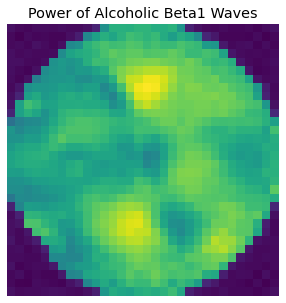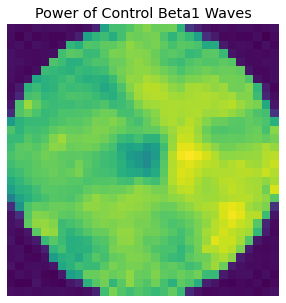

# Beta 2 Waves

### Hypothesis, Beta two waves should be more prevalent in Control Group



In [ ]:
show_image(alcAlpha_mean,figsize=(5,5),title='Alcoholic average Beta 2 Waves')
show_image(conAlpha_mean,figsize=(5,5),title='Control average Beta 2 Waves')


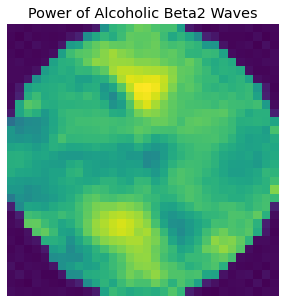
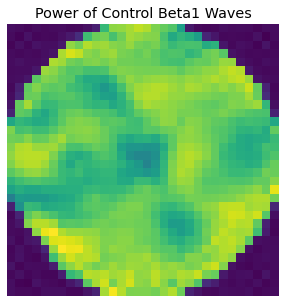

# Key Difference: Beta 3 waves

### hypothesis: Should be more prevalent in Alcoholics 


In [ ]:
show_image(alcBeta_mean,figsize=(5,5),title='Alcoholic average Beta 3 Waves')
show_image(conBeta_mean,figsize=(5,5),title='Control average Beta 3 Waves')

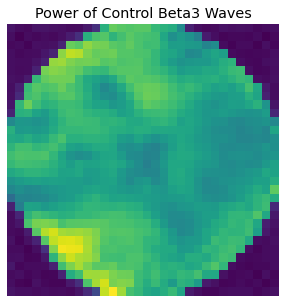
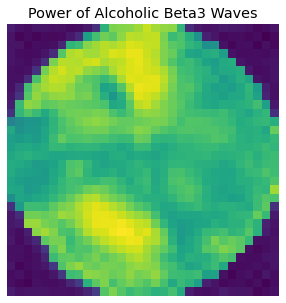

# Training the model

In [ ]:
%cd /home/james/

root_dir = "/home/james/EEG_Images_fft"
EEG_Con_Path = os.path.join(root_dir,'Con')
EEG_Alc_Path = os.path.join(root_dir,'Alc')

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]


In [ ]:
from fastbook import GetAttr
from fastbook import DataBlock
from fastbook import add_props
from fastbook import ImageBlock
from fastbook import CategoryBlock
from fastbook import get_image_files
from fastbook import RandomSplitter
from fastbook import parent_label
from fastbook import Resize

from fastbook import Path
from fastbook import cnn_learner
from fastbook import error_rate
from fastbook import resnet18
from fastbook import ClassificationInterpretation
from fastbook import xresnet18

# Image Classifier Using Theta, Alpha, Beta waves as RBG channels in an image format

In [ ]:
%cd /home/james/

root_dir = "/home/james/EEG_Images_fft"
EEG_Con_Path = os.path.join(root_dir,'Con')
EEG_Alc_Path = os.path.join(root_dir,'Alc')

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]

NumOfControlImages = len(List_EEG_Con) 
NumOfAlchImages = len(List_EEG_Alc) 

print(f'Control Group size {NumOfControlImages}')
print(f'Alcholic Group size: {NumOfAlchImages}')

class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(32,32))

dls = EEGs.dataloaders
destination =Path(root_dir)
path = destination
fns = get_image_files(path)
dls = EEGs.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=16, nrows=4)

![image.png](https://i.imgur.com/QwxjVr5.png)

In [ ]:
EEGs = EEGs.new()
dls = EEGs.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, xresnet18, metrics=error_rate)
learn.fine_tune(6)

![image.png](https://i.imgur.com/43jJnat.png)

In [ ]:
interp_round1 = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp_round1.plot_confusion_matrix()

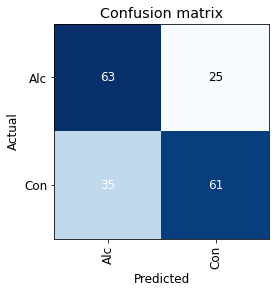

# Results: A 10% improvment from before, but still not enough


### Reasons: The wrong features

### A time series only contains only time and amplitude information

### The Fourier transform only contains frequency and power information

#### It does not tell us about time because the model's equation assumes that a frequency is present throughout the sampling period

### A compromise is needed


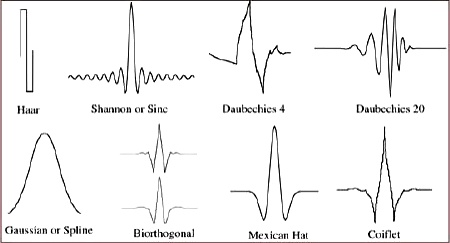

# A more accurate model: Morlet Wavelet

# Brain Waves are more complex than sine waves and need a different equation to model it

### Brain waves can be at different frequencies at different times at different intensities

# Enter Wavelets

### Used in image / audio compression

### It's much more efficient to model the audio as a wavlet than to contain every last granular detail since the information is represented mathematically

### Can model more complex waves such as a brain wave than a fourier transform can



# Step 4: Choosing the relevant frames

### This was one of the most labor intensive part of the project. Due to how the 64 channels would heavily correlate with one another, it was necessary to put them into groups.

### There were various options to do this

#### Option One: random selection

Advantages: simple and straightforward to code

Disadvantages: subject to looking at the wrong information, repeating the mistake of the first attempt.

### Option Two: correlate the data between the alcoholic and control groups, examine the channels that differ the most between the two

Advantages: Would likely yield results by looking at the right place

Disadvantages: Compromises integrity of the data 

### Option Three: Cluster the highly correlated channels together and sample the different clusters

Advantage: would lead to a wider spectrum of data being analysed

Disadvantage: could overlook important sensor channels by being too broad.

### Option Four: Look at the channels that have been shown to have statistically significant differences in alcoholics, and see the results

Advantage: Very easy to code

Disadantage: could compromise integrity of data if not approached correctly.

## Here I chose options number three and four. Option three because it was a compromise between random selection that deals with the correlation problem

## I also chose number four as an exploratory analysis, since it required very little unique code, and may yield interesting results that could later be verified using hypothesis testing


### Clustering of the channels by K-means applied to time series

![image.png](https://i.imgur.com/itIgfQ6.png)

In [ ]:
# Step 2 Analyse Channels by means of hierarchical clustering

# Calculating the similarities in the time series, 
# Grouping together 

#Functions

def cluster_channels(distance_matrix,num_of_clusters):

  def hierarchical_clustering(dist_mat, method='ward'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)

    # Plotted visualization

    #fig = plt.figure(figsize=(16, 8))
    #dn = dendrogram(Z)
    #plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    #plt.show()

    return Z

  linkage_matrix = hierarchical_clustering(distance_matrix)

  # The cluster labels match the rows in the one second frame

  cluster_labels = fcluster(linkage_matrix, num_of_clusters, criterion='maxclust')
  return cluster_labels

def select_clusters(cluster_index,totalFramesToInclude):
    
    unique_clusters = np.unique(cluster_index)
    unique_clusters_count = np.unique(cluster_index,return_counts=True)[1]
    #print(len(unique_clusters_count))
    unique_clusters_count[unique_clusters_count != 0]
    #print(len(unique_clusters_count))
    
    # Sort the order of the clusters into the largest to smallest

    unique , count = np.unique(cluster_index, return_counts=True)

    count_sort_ind = np.argsort(-count)

    size_sorted_clusters = unique[count_sort_ind]

  # Include all the clusters that are larger than one


    #largerClusters = [k for k,v in enumerate(unique_clusters_count) if v > 1]

    largerClusters = [k for k,v in enumerate(size_sorted_clusters) if v > 1]

    # Below is an extremely important line, removes a zero from the index 
    # that does not belong in the cluster index. Otherwise everything breaks

    largerClusters = [x for x in largerClusters if not x == 0]
  
    largerClusters = sorted(largerClusters)
    

    # If there are more 2+ size clusters than 9, then hanle that

    if len(largerClusters) == totalFramesToInclude:
      #largerClusters = sorted(largerClusters)

      #Sort by size
      final_clusters = largerClusters

    # If there are more, chose the larger clusters
    elif len(largerClusters) > totalFramesToInclude:
      
      largerClusters = sorted(largerClusters)
      
      x = totalFramesToInclude
      largerClusters = largerClusters[0:x]


    elif len(largerClusters) < totalFramesToInclude: # Choose the larger clusters, and then randomly select size one clusters


      sizeOneClusters = list(set(unique_clusters).difference(largerClusters))

      # Choosing the random small clusters to populate a list
      numToRandSelect = totalFramesToInclude - len(largerClusters)
      random_small_clusters = random.sample(sizeOneClusters,numToRandSelect)
      largerClusters = largerClusters + random_small_clusters

    else:
      Exception('size error')

    if not len(largerClusters) == totalFramesToInclude:
      print('not ok')
    
    #print(len(largerClusters))

    final_clusters = np.array(largerClusters)
    
    return final_clusters

# Step 3 Select the final clusters to transform


def select_channels_to_transform(trial_index, clusters_index, final_clusters_index):
  
  """
  outputs indicies of the channels that will be called out of the
  64 Channel EEG frame

  Takes in a list of clusters that will be uses

  """
  
  finalChannelsIndex = {}


  for i in np.nditer(final_clusters_index): #range(1,len(final_clusters_index)-1):
    #print(i)
    timeSeriesIndices = np.where(clusters_index==i)[0]
    if timeSeriesIndices.shape[0] == 0:
      print(len(timeSeriesIndices)) 

    randomSelectionIndex = np.random.choice(timeSeriesIndices)
    finalChannelsIndex[randomSelectionIndex] = i
  
  return finalChannelsIndex




### Peeking at the data: Looking at each cluster in a print test

These graphs show time, and frequency data visualized in two dimensions

The bottom area of the chart has low resolution information the low frequencies that don't change often.

The top areas of the chart have higher resolution information on the high frequencies that do change more often. 

In [ ]:

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf
    
for cluster in np.unique(cluster_labels):
  print(f'####################New cluster {cluster}  ################3')

  for channel in Alc_Example.index:
    if cluster_labels[channel] == cluster:
        print(cluster)
        print(channel)
        signal = Alc_Example.loc[channel]
        x = signal

        fig, ax = plt.subplots(figsize=(3,3))
        plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.margins(x=0,y=0)
        plt.tight_layout(pad=0, rect=(0,0,0,0))

        np_array = fig2data(fig)



        #plt_array = get_img_from_fig(plt,dpi=80)

        plt.show()



# Clustering the channels produced groups which had similar graphs

Cluster (Number): Size

Cluster 1: 2			Cluster 2: 6 			Cluster 3: 2 			Cluster 4: 17

Cluster 5: 8			Cluster 6: 1			Cluster 7: 5			Cluster 8: 1

Cluster 9: 17		Cluster 10: 2		Clusters 11, 12, 13 and 14: All size 1

![image.png](https://i.imgur.com/2WizDDb.png)![image.png](https://i.imgur.com/2rCHMQy.png)![image.png](https://i.imgur.com/nbvwdNK.png)![image.png](https://i.imgur.com/MBQK2oN.png)![image.png](https://i.imgur.com/AvyOaTg.png)![image.png](https://i.imgur.com/LfBUExS.png)![image.png](https://i.imgur.com/UbOTZII.png)![image.png](https://i.imgur.com/FyJtkQt.png)![image.png](https://i.imgur.com/CK608xV.png)

### Feature Extraction code

### Features to be extracted 

#### Time (x) axis 0 to 255 samples 256htz

### Y axis (Frequency) Bottom has low frequency, 

### Z (color, prevalence)

In [ ]:
# Step 1, pull out all of the samples
# from each Dataset

def pull_one_second_frame(row, trial_index,input_data):

    """
    Indexes the dataframe for the unique name and trial,
    then creates a 64 by 256 pivot table
    containing the time, channel, and sensor voltage information

    """
    return input_data[(input_data['trial number'] == trial_index.loc[row]['trial number']) &
             (input_data['name'] == trial_index.loc[row]['name'])].pivot_table(index='channel', columns='time', values = 'sensor value')

# Part Two Feature Extraction of Wavelets

In [ ]:
# Part 2 

# Step 4 Conversion to Wavelet, Plotting, and Numpy conversion
def wavelet_transformation_plot_to_array(signal):
    dt = 0.8
    time = np.arange(0,256,1)
    scales = np.arange(1, 256)

  #def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
  #                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
  

    def plot_wavelet(ax, time, signal, scales, waveletname = 'morl', 
                    cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
        
        dt = time[1] - time[0]
        [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
        power = (abs(coefficients)) ** 2
        period = 1. / frequencies
        #levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]

        # levels corresponding to different wavelengths of brain wave


        levels = [0.1,4.3,7.3,21.3,32,64,512]

        contourlevels = np.log2(levels)
        
        im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
        
        # turns off the plot
        plt.ioff()


        #ax.set_title(title, fontsize=20)
        #ax.set_ylabel(ylabel, fontsize=18)
        #ax.set_xlabel(xlabel, fontsize=18)
        
        yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        
        ax.invert_yaxis()
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], -1)
        return yticks, ylim

    x = signal
    title = ''
    ylabel = ''
    xlabel = ''



    fig, ax = plt.subplots(figsize=(4,4))
    plt.ioff()
    plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.margins(x=0,y=0)
    plt.tight_layout(pad=0, rect=(0,0,0,0))

    # Numpy conversion 

    def fig2data ( fig ):
        """
        @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
        @param fig a matplotlib figure
        @return a numpy 3D array of RGBA values
        """
        # draw the renderer
        fig.canvas.draw ( )
    
        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = np.frombuffer ( fig.canvas.tostring_argb(), dtype=np.uint8 )
        buf.shape = ( w, h,4 )
    
        # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
        buf = np.roll ( buf, 3, axis = 2 )
        return buf
    plt.close()
    outputArray = fig2data(fig)

    return outputArray

In [ ]:
# part 3 array processing and filtering

def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )




In [ ]:
## Step 8: Collaging the images and saving them

# Functions to name each image

def name_image(trial, trial_index,experiment_condition=''):
  """
  creates a file name for the image as a .jpg
  includes the trial number, subjectID, and the experiment condition

  OUTPUT = EXPCONDITION_TRIALNUMBER_SUBJECTID.jpg

  """

  trial_num = str(trial_index.loc[trial]['trial number'])
  subject_ID = str(trial_index.loc[trial]['name'])

  fileName = experiment_condition + '_' + trial_num + '_' + subject_ID + '.jpg' 

  return fileName

def name_image_a_or_c(trial, trial_index):
  """
  creates a file name for the image as a .jpg
  includes the trial number, subjectID, and the experiment condition

  OUTPUT = EXPCONDITION_TRIALNUMBER_SUBJECTID.jpg

  """

  trial_num = str(trial_index.loc[trial]['trial number'])
  subject_ID = str(trial_index.loc[trial]['name'])
  experiment_condition = str(trial_index.loc[trial]['trial info'])

  fileName = experiment_condition + '_' + trial_num + '_' + subject_ID + '.jpg' 

  return fileName


#### Handling the Directories

In [ ]:
# Code to create directories

# Two groups Group 1: Fast AI Binary Classification

# Group 2: Orignal Conditions for experiment

#Base directory
!mkdir /home/james
!mkdir /home/james/EEG

fastAI_root_dir = '/home/james/EEG'

#Alc and Con Group 
!mkdir /home/james/EEG/Con
!mkdir /home/james/EEG/Alc
Alc_Dir = '/home/james/EEG/Alc'
Con_Dir = '/home/james/EEG/Con'

!mkdir /home/james/EEG_Groups

orig_root_dir = '/home/james/EEG_Groups'

#Alc Group 

!mkdir /home/james/EEG_Groups/alc_s1Obj
!mkdir /home/james/EEG_Groups/alc_s2Match
!mkdir /home/james/EEG_Groups/alc_s2Nomatch

Alc_S1Obj_Dir = '/home/james/EEG_Groups/alc_s1Obj'
Alc_S2Match_Dir = '/home/james/EEG_Groups/alc_s2Match'
Alc_S2Nomatch_Dir = '/home/james/EEG_Groups/alc_s2Nomatch'

#Control Group

!mkdir /home/james/EEG_Groups/con_s1Obj
!mkdir /home/james/EEG_Groups/con_s2Match
!mkdir /home/james/EEG_Groups/con_s2Nomatch

Con_S1Obj_Dir = '/home/james/EEG_Groups/con_s1Obj'
Con_S2Match_Dir = '/home/james/EEG_Groups/con_s2Match'
Con_S2Nomatch_Dir = '/home/james/EEG_Groups/con_s2Nomatch'

# For reference



In [ ]:
Alc_S1Obj_Index['trial info'] = 'a_S1Obj'
Alc_S2Match_Index['trial info'] = 'a_S2Match'
Alc_S2Nomatch_Index['trial info'] = 'a_S2Nomatch'

Con_S1Obj_Index['trial info'] = 'c_S1Obj'
Con_S2Match_Index['trial info'] = 'c_S2Match'
Con_S2Nomatch_Index['trial info'] = 'c_S2Nomatch'


All_Alcs = pd.concat([Alc_S1Obj_Index,Alc_S2Match_Index,Alc_S2Nomatch_Index])
All_Cons = pd.concat([Con_S1Obj_Index,Con_S2Match_Index,Con_S2Nomatch_Index])

All_Alcs.reset_index(drop=True,inplace=True)
All_Cons.reset_index(drop=True,inplace=True)

In [ ]:
#!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
#!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'


# Code Execution

In [ ]:
# Feature Extraction for alcoholic group


#alc_wavelet_img_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
#con_wavelet_img_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'


# Variables
input_data = EEG_data
trial_index = All_Alcs
#experCond = 'c_S2Nomatch'
img_directory = Alc_Dir


num_of_clusters = 14
totalFramesToInclude = 9 



for trial in trial_index.index: #runs through trial index
  #print('new row')
  EEG_Frame = pull_one_second_frame(trial,trial_index,input_data)

  # Analyse the EEG clusters
  cluster_labels = cluster_channels(EEG_Frame,num_of_clusters)

  final_clusters = select_clusters(cluster_labels,totalFramesToInclude)

  ########### Step 2 Selecting the channels for analysis

  final_channels = select_channels_to_transform(trial_index,cluster_labels,final_clusters)
  #print(final_channels)

  ########### Step 3 Processing the arrays

  array_dict = {}

  for key in final_channels.keys():
    #print(key)
    signal = EEG_Frame.loc[key]

    # Raw array representation of plots
    np_array = wavelet_transformation_plot_to_array(signal)
    plt.close()
    np_array = rgba2rgb(np_array)

    # Grayscale filter to decrease size of images

    #np_array = np.dot(np_array[...,:3], [0.287,0.299, 0.814])


    # Cropping the array



    array_dict[key] = np_array


  ############ Step 4 ### Creating a collage

  ordered_keys = list(array_dict.keys())

  for (k,v) in array_dict.items():
    array_dict[k] = cv2.resize(v,(200,200))


  horizontalRow1 = np.hstack([array_dict[ordered_keys[0]],array_dict[ordered_keys[1]],array_dict[ordered_keys[2]]])
  horizontalRow2 = np.hstack([array_dict[ordered_keys[3]],array_dict[ordered_keys[4]],array_dict[ordered_keys[5]]])
  horizontalRow3 = np.hstack([array_dict[ordered_keys[6]],array_dict[ordered_keys[7]],array_dict[ordered_keys[8]]])


  collaged_array = np.vstack([horizontalRow1,horizontalRow2,horizontalRow3])

  nameOfCollage = name_image_a_or_c(int(trial),trial_index)

  ######### Step 5 Save image

  filePath = os.path.join(img_directory,nameOfCollage)
  cv2.imwrite(filePath,collaged_array)

  




In [ ]:
# Feature Extraction for Control Group

# Config variables
input_data = EEG_data_control
trial_index = All_Cons
#experCond = '' 
img_directory = Con_Dir


num_of_clusters = 14
totalFramesToInclude = 9 



for trial in trial_index.index: #runs through trial index
  #print('new row')
  EEG_Frame = pull_one_second_frame(trial,trial_index,input_data)

  # Analyse the EEG clusters
  cluster_labels = cluster_channels(EEG_Frame,num_of_clusters)

  final_clusters = select_clusters(cluster_labels,totalFramesToInclude)

  ########### Step 2 Selecting the channels for analysis

  final_channels = select_channels_to_transform(trial_index,cluster_labels,final_clusters)
  #print(final_channels)

  ########### Step 3 Processing the arrays

  array_dict = {}

  for key in final_channels.keys():
    #print(key)
    signal = EEG_Frame.loc[key]

    # Raw array representation of plots# Config varialbes

    np_array = wavelet_transformation_plot_to_array(signal)
    np_array = rgba2rgb(np_array)

    # Greyscale filter to decrease size of images

    #np_array = np.dot(np_array[...,:3], [0.287,0.299, 0.814])

    array_dict[key] = np_array


  ############ Step 4 ### Creating a collage

  ordered_keys = list(array_dict.keys())

  for (k,v) in array_dict.items():
    array_dict[k] = cv2.resize(v,(200,200))


  horizontalRow1 = np.hstack([array_dict[ordered_keys[0]],array_dict[ordered_keys[1]],array_dict[ordered_keys[2]]])
  horizontalRow2 = np.hstack([array_dict[ordered_keys[3]],array_dict[ordered_keys[4]],array_dict[ordered_keys[5]]])
  horizontalRow3 = np.hstack([array_dict[ordered_keys[6]],array_dict[ordered_keys[7]],array_dict[ordered_keys[8]]])


  collaged_array = np.vstack([horizontalRow1,horizontalRow2,horizontalRow3])

  nameOfCollage = name_image_a_or_c(int(trial),trial_index)

  ######### Step 5 Save image

  filePath = os.path.join(img_directory,nameOfCollage)
  cv2.imwrite(filePath,collaged_array)

  


#### More directory handling

In [ ]:
Alc_S1Obj_Dir = '/home/james/EEG_Alc_Wavelets/alc_s1Obj'
Alc_S2Match_Dir = '/home/james/EEG_Alc_Wavelets/alc_s2Match'
Alc_S2Nomatch_Dir = '/home/james/EEG_Alc_Wavelets/alc_s2Nomatch'

#Control Group

!mkdir /home/james/EEG_Alc_Wavelets/con_s1Obj
!mkdir /home/james/EEG_Alc_Wavelets/con_s2Match
!mkdir /home/james/EEG_Alc_Wavelets/con_s2Nomatch

Con_S1Obj_Dir = '/home/james/EEG_Alc_Wavelets/con_s1Obj'
Con_S2Match_Dir = '/home/james/EEG_Alc_Wavelets/con_s2Match'
Con_S2Nomatch_Dir = '/home/james/EEG_Alc_Wavelets/con_s2Nomatch'

# For reference

In [ ]:
# Handling directories
"""

gdrivePath = '/content/drive/MyDrive/Colab_Data/EEG'

%cd '/content/drive/MyDrive/Colab_Data/EEG'

!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG'

!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'

#Alc_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
#Con_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'

for fileName in os.listdir(Alc_S1Obj_Dir):
  shutil.copy(os.path.join(Alc_s1Obj_Dir,fileName), os.path.join(Alc_Dir,fileName))
for fileName in os.listdir(Alc_S2Match_Dir):
  shutil.copy(os.path.join(Alc_S2Match_Dir,fileName), os.path.join(Alc_Dir,fileName))
for fileName in os.listdir(Alc_S2Nomatch_Dir):
  shutil.copy(os.path.join(Alc_S2Nomatch_Dir,fileName), os.path.join(Alc_Dir,fileName))

for fileName in os.listdir(Con_S1Obj_Dir):
  shutil.copy(os.path.join(Con_s1Obj_Dir,fileName), os.path.join(Con_Dir,fileName))
for fileName in os.listdir(Con_S2Match_Dir):
  shutil.copy(os.path.join(Con_S2Match_Dir,fileName), os.path.join(Con_Dir,fileName))
for fileName in os.listdir(Con_S2Nomatch_Dir):
  shutil.copy(os.path.join(Con_S2Nomatch_Dir,fileName), os.path.join(Con_Dir,fileName))
"""

"""
import os
import shutil
!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'

Alc_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
Con_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'


for fileName in os.listdir(Alc_S1Obj_Dir):
  shutil.copy(os.path.join(Alc_s1Obj_Dir,fileName), os.path.join(Alc_Dir,fileName))
for fileName in os.listdir(Alc_S2Match_Dir):
  shutil.copy(os.path.join(Alc_S2Match_Dir,fileName), os.path.join(Alc_Dir,fileName))
"""

# Part 3 Training the model

Overview:

Control group: 388 Images (collage of 9 channels) Total Channels: 3592
Alcoholic group: 384 (collage of 9 channels) Total Channels: 3456

80 Percent allocated for training
20 Percent allocated for validation 



In [ ]:


#Alc_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
#Con_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'

Alc_Dir = '/home/james/EEG/Alc'
Con_Dir = '/home/james/EEG/Con'


EEG_Con_Path = Alc_Dir
EEG_Alc_Path = Con_Dir

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]

#root_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/'
root_dir = '/home/james/EEG'

In [ ]:
NumOfControlImages = len(List_EEG_Con) 
NumOfAlchImages = len(List_EEG_Alc) 

print(f'Control Group size {NumOfControlImages}')
print(f'Alcholic Group size: {NumOfAlchImages}')

In [ ]:
from PIL import Image
picked_image = 77
im = Image.open(List_EEG_Alc[picked_image])
im.to_thumb(225,225)

![image.png](https://i.imgur.com/cUctMw2.png)

In [ ]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [ ]:
EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    item_tfms=Resize(225,225)
    )

In [ ]:

dls = EEGs.dataloaders(root_dir)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

![image.png](https://i.imgur.com/2Byh59z.png)

In [ ]:
del learn

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(6)

![image.png](https://i.imgur.com/UJ5htrN.png)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(6)

![image.png](https://i.imgur.com/g2ek8LW.png)

In [ ]:
learn.save('eegResnet34.mdl')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()


![image.png](https://i.imgur.com/QxbjXDM.png)

In [ ]:
interp.plot_top_losses(15)


# Improving the results

### Attempting to focus in on the frontal areas of the brain, the right oppcipital lobe, and the temporal lobe 

In [ ]:
import re

In [ ]:
sensor_positions = list(EEG_data['sensor position'].unique())


In [ ]:
#sensors_of_interest = ['Fp1','AF3','F3','F7','Fp2','AF4','F4','F8','T8']

microDF = input_data[(input_data['trial number'] == trial_index.loc[row]['trial number']) &
             (input_data['name'] == trial_index.loc[row]['name'])]
snapshot = microDF[microDF['time'] == 0]
channels_position_index = snapshot[['channel','sensor position']]


channels_position_index.reset_index(drop=True,inplace=True)
channels_of_interest = []

for position in sensors_of_interest:
  idx = channels_position_index[channels_position_index['sensor position'] == position]

  channels_of_interest.append(int(idx['channel']))
 
int(idx['channel'])

In [ ]:
channels_of_interest

In [ ]:
!mkdir /home/james/EEG_Frontal_Cortex

!mkdir /home/james/EEG_Frontal_Cortex/Alc
!mkdir /home/james/EEG_Frontal_Cortex/Con

FC_Alc_Dir = '/home/james/EEG_Frontal_Cortex/Alc'
FC_Con_Dir = '/home/james/EEG_Frontal_Cortex/Con'

In [ ]:
# Pulling it together

# Config varialbes
input_data = EEG_data
trial_index = All_Alcs
#experCond = 'c_S2Nomatch'
img_directory = FC_Alc_Dir


num_of_clusters = 14
totalFramesToInclude = 9 



for trial in trial_index.index: #runs through trial index
  #print('new row')
  EEG_Frame = pull_one_second_frame(trial,trial_index,input_data)

  # Analyse the EEG clusters
  #luster_labels = cluster_channels(EEG_Frame,num_of_clusters)

  #final_clusters = select_clusters(cluster_labels,totalFramesToInclude)

  ############ Step 2 Selecting the channels for analysis

  final_channels = channels_of_interest
  
  #select_channels_to_transform(trial_index,cluster_labels,final_clusters)
  #print(final_channels)

  ########### Step 3 Processing the arrays

  array_dict = {}

  for key in final_channels.keys():
    #print(key)
    signal = EEG_Frame.loc[key]

    # Raw array representation of plots
    np_array = wavelet_transformation_plot_to_array(signal)
    plt.close()
    np_array = rgba2rgb(np_array)

    # Grayscale filter to decrease size of images

    #np_array = np.dot(np_array[...,:3], [0.287,0.299, 0.814])


    # Cropping the array



    array_dict[key] = np_array


  ############ Step 4 ### Creating a collage

  ordered_keys = list(array_dict.keys())

  for (k,v) in array_dict.items():
    array_dict[k] = cv2.resize(v,(200,200))


  horizontalRow1 = np.hstack([array_dict[ordered_keys[0]],array_dict[ordered_keys[1]],array_dict[ordered_keys[2]]])
  horizontalRow2 = np.hstack([array_dict[ordered_keys[3]],array_dict[ordered_keys[4]],array_dict[ordered_keys[5]]])
  horizontalRow3 = np.hstack([array_dict[ordered_keys[6]],array_dict[ordered_keys[7]],array_dict[ordered_keys[8]]])


  collaged_array = np.vstack([horizontalRow1,horizontalRow2,horizontalRow3])

  nameOfCollage = name_image_a_or_c(int(trial),trial_index)

  ######### Step 5 Save image

  filePath = os.path.join(img_directory,nameOfCollage)
  cv2.imwrite(filePath,collaged_array)

  

In [ ]:
# Pulling it together

# Config varialbes
input_data = EEG_data_control
trial_index = All_Cons
#experCond = 'c_S2Nomatch'
img_directory = FC_Con_Dir


num_of_clusters = 14
totalFramesToInclude = 9 



for trial in trial_index.index: #runs through trial index
  #print('new row')
  EEG_Frame = pull_one_second_frame(trial,trial_index,input_data)

  # Analyse the EEG clusters
  #luster_labels = cluster_channels(EEG_Frame,num_of_clusters)

  #final_clusters = select_clusters(cluster_labels,totalFramesToInclude)

  ############ Step 2 Selecting the channels for analysis

  #final_channels = channels_of_interest
  
  #select_channels_to_transform(trial_index,cluster_labels,final_clusters)
  #print(final_channels)

  ########### Step 3 Processing the arrays

  array_dict = {}

  for key in final_channels.keys():
    #print(key)
    signal = EEG_Frame.loc[key]

    # Raw array representation of plots
    np_array = wavelet_transformation_plot_to_array(signal)
    plt.close()
    np_array = rgba2rgb(np_array)

    # Grayscale filter to decrease size of images

    #np_array = np.dot(np_array[...,:3], [0.287,0.299, 0.814])


    # Cropping the array



    array_dict[key] = np_array


  ############ Step 4 ### Creating a collage

  ordered_keys = list(array_dict.keys())

  for (k,v) in array_dict.items():
    array_dict[k] = cv2.resize(v,(200,200))


  horizontalRow1 = np.hstack([array_dict[ordered_keys[0]],array_dict[ordered_keys[1]],array_dict[ordered_keys[2]]])
  horizontalRow2 = np.hstack([array_dict[ordered_keys[3]],array_dict[ordered_keys[4]],array_dict[ordered_keys[5]]])
  horizontalRow3 = np.hstack([array_dict[ordered_keys[6]],array_dict[ordered_keys[7]],array_dict[ordered_keys[8]]])


  collaged_array = np.vstack([horizontalRow1,horizontalRow2,horizontalRow3])

  nameOfCollage = name_image_a_or_c(int(trial),trial_index)

  ######### Step 5 Save image

  filePath = os.path.join(img_directory,nameOfCollage)
  cv2.imwrite(filePath,collaged_array)

In [ ]:
# Move all the alc and control files into 

#Alc_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
#Con_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'


EEG_Con_Path = FC_Alc_Dir
EEG_Alc_Path = FC_Con_Dir

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]

#root_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/'
root_dir = '/home/james/EEG'

In [ ]:
NumOfControlImages = len(List_EEG_Con) 
NumOfAlchImages = len(List_EEG_Alc) 

print(f'Control Group size {NumOfControlImages}')
print(f'Alcholic Group size: {NumOfAlchImages}')

In [ ]:
from PIL import Image
picked_image = 47
im = Image.open(List_EEG_Alc[picked_image])
im.to_thumb(225,225)

In [ ]:
interp.plot_confusion_matrix()


interp.plot_top_losses(50)


   # Have a nice structure


In [ ]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [ ]:
EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    item_tfms=Resize(225,225)
    )

In [ ]:
# a way to modify the datablock

dls = EEGs.dataloaders(root_dir)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch	train_loss	valid_loss	error_rate	time

0	0.875190	1.549510	0.548387	03:08

1	0.683642	1.584309	0.526882	03:08

2	0.490144	1.312087	0.430108	03:16

3	0.380837	0.864145	0.311828	03:12

4	0.299431	0.740602	0.258065	03:08

5	0.249155	0.724146	**0.247312**	03:12

Final error rate: **0.25 percent**

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(6)

epoch	train_loss	valid_loss	error_rate	time

0	0.875190	1.549510	0.548387	03:08

1	0.683642	1.584309	0.526882	03:08

2	0.490144	1.312087	0.430108	03:16

3	0.380837	0.864145	0.311828	03:12

4	0.299431	0.740602	0.258065	03:08

5	0.249155	0.724146	**0.247312**	03:12

Final error rate: **0.25**

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()


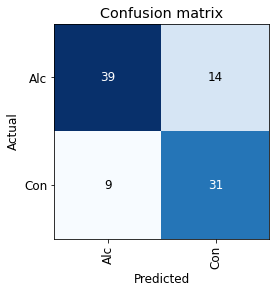

In [ ]:
interp.plot_top_losses(6)


![image.png](https://i.imgur.com/Yln5Xa9.png)

# Conclusion

Conclusion: Although the two groups do exhibit statistically significant differences, it doesn’t translate to perfect accuracy
Leonidas (NIIT University, Mumbai, India) achieved a p value below 0.001
Kaggle

# Thank you for making it this far

### To any engineers out there, this was my first attempt at signal processing, and any feedback or criticism would be very much appreciated, especially when it had to do with the wavelet transforms
